# CS-E4600 Data Mining - Programming project

Adam Ilyas 725819

The tasks you have to complete for the programming project are the following:
1. design and implement your own graph-partitioning method;
2. submit your solution, which should include the source code you developed and a report;

We will use graphs from the Stanford Network Analysis Project (SNAP)

http://snap.stanford.edu/data/index.html

in particular, you can consider the following 5 collaboration networks:

```
ca-AstroPh, ca-CondMat, ca-GrQc, ca-HepPh, ca-HepTh
```

File formate
first line:
`# graphID numOfVertices numOfEdges k`

Subsequent values:
`vertex1ID vertex2ID`

We will be implementing 3 algorithms here
1. [Unnormalized spectral clustering](#algo1)
2. [Normalized spectral clustering (generalized eigenproblem)](#algo2)
3. [Normalized spectral clustering (generalized eigenproblem) W normalized U](#algo3)
3. [Normalized spectral clustering (normalize U)](#algo4)

In [1]:
import networkx as nx 
import scipy as sp
import numpy as np

In [2]:
file_path = './graphs-1/ca-HepTh.txt'
values = open(file_path).read().split('\n')
graph_info = values[0].split()
print(graph_info)

['#', 'ca-HepTh', '8638', '24827', '20']


In [3]:
file_path = './graphs-1/ca-HepTh.txt'
values = open(file_path).read().split('\n')
graph_info = values[0]
print(graph_info)

k = int(graph_info.split()[-1])
graph = nx.read_edgelist(file_path)

# ca-HepTh 8638 24827 20


## Graph-partitioning task:
Given an undirected graph $G = (V, E)$ and an integer
$k > 1$ 

we want to partition the set of vertices $V$ into $k$ communities  
$V_1 , \dots, V_k$ so that $\cap_{i=1}^k V_i = V$

We want our communities $V_1 , \dots, V_k$ to be as much seperate from each other as possible. We also want the communities to have roughly equal size. 

Thus, we will evaluate the goodness of
a partition $V_1 , \dots, V_k$ by **minimizing** the objective function:

$$\phi(V_1 , \dots, V_k) = \frac{E(V_1 , \dots, V_k)}{\min_{1 \leq i \leq k} |V_i|}$$

where $E(V_1 , \dots, V_k)$ is the set of edges of G that is “cut” by the k communities: 
$$E(V_1 , \dots, V_k) = \{ (u,v) \in E \;| \; u \in V_i \text{ and } v \in V_j \text{ where } i \neq j \}$$

You should implement a program that reads a problem instance in the format specified above and
produces a partition $V_1 , \dots, V_k$ for which the objective function $\phi(V_1 , \dots, V_k)$ is as small as possible

<a id='algo1'></a>
## Algorithm 1: Unnormalized spectral clustering
**input**: graph adjacency matrix $A$, number $k$
1. form diagonal matrix $D$
2. form unormalized Laplacian $L = D − A$
3. compute the first $k$ eigenvectors $u_1 , \dots, u_k$ of $L$ (unnormalized Laplacian)
4. form matrix $U \in \texttt{R}^{n \times k}$ with columns $u_1, \dots, u_k$
5. consider the i-th row of $U$ as point $y_i \in \texttt{R}^k, \; i=1, \dots, n$
6. cluster (kmeans) the points $\{y_i\}_{i=1, \dots, n}$ into clusters $C_1, \dots, C_k$


**output** clusters $A_1, \dots A_k$


In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [4]:
file_path = './graphs-1/ca-HepTh.txt'
values = open(file_path).read().split('\n')
graph_info = values[0]
print(graph_info)

k = int(graph_info.split()[-1])
graph = nx.read_edgelist(file_path)

# ca-HepTh 8638 24827 20


In [5]:
# form diagonal matrix D
adjacency_matrix = nx.adjacency_matrix(graph)
diagonal_matrix = np.diag(np.ravel(np.sum(adjacency_matrix, axis = 1)))

# form unnormalized laplacian
unnormalized_laplacian = diagonal_matrix - adjacency_matrix

# first k eigenvectors of L
eigenvalues, eigenvectors = np.linalg.eigh(unnormalized_laplacian)
u = eigenvectors[:, :k]
u.shape

(8638, 20)

In [6]:
# cluster using k means
kmeans = KMeans(n_clusters=k).fit(u)
labels = kmeans.labels_

counts = {}
for label in labels:
    if label in counts:
        counts[label] += 1
    else:
        counts[label] = 0
print(counts)

{0: 8394, 10: 7, 12: 23, 4: 14, 18: 7, 14: 15, 15: 14, 8: 26, 5: 6, 2: 27, 13: 5, 11: 8, 19: 14, 6: 10, 17: 9, 1: 18, 16: 5, 9: 4, 3: 5, 7: 7}


In [7]:
# Calculate partition cost (kmeans.labels_, k, graph.edges)
# calculate cut
# for every edge, there is a cut if
# u and v does not belong to the same cluster
cuts = 0

if len(counts) != k:
    partition_cost = float('-inf')
else:
    for (u, v) in list(graph.edges):
        # if u and v not same cluster
        if labels[int(u)] != labels[int(v)]:
            cuts += 1
            
    min_cluster_size = min(counts.values())
    partition_cost = cuts/ min_cluster_size
    print('No. of cuts: %s' % cuts) 
    print('Cost: %s' % partition_cost) 

No. of cuts: 1219
Cost: 304.75


## Algorithm 2: Normalized spectral clustering (generalized eigenproblem)
<a id='algo2'></a>
**input**: graph adjacency matrix $A$, number $k$
1. form diagonal matrix $D$
2. form unnormalized Laplacian $L = D − A$

3. compute the first $k$ eigenvectors $u_1 , \dots, u_k$ of the
_generalized eigenproblem_ $L \mathbf{u} = \lambda D \mathbf{u}$
(eigenvectors of $L_{rw}$)

4. form matrix $U \in \texttt{R}^{n \times k}$ with columns $u_1, \dots, u_k$
5. consider the i-th row of $U$ as point $y_i \in \texttt{R}^k, \; i=1, \dots, n$
6. cluster (kmeans) the points $\{y_i\}_{i=1, \dots, n}$ into clusters $C_1, \dots, C_k$

**output** clusters $A_1, \dots A_k$

This algorithm is similar to 
[algorithm 1](#algo1). The difference is in step 3 where we find the
eigenvectors $u_1 , \dots, u_k$ of the
_generalized eigenproblem_ instead of the _unnormalized laplacian_

$L_{rw} := I - D^{-1} A$

`d_inverse` $= D^{-1}$ 

In [8]:
# laplacian
identity_matrix = np.identity(adjacency_matrix.shape[0])
d_inverse = np.linalg.inv(diagonal_matrix)
laplacian_rw = np.subtract(identity_matrix, d_inverse@adjacency_matrix)

# first k eigenvectors of L
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_rw)
U = eigenvectors[:, :k]
U.shape

(8638, 20)

In [9]:
# cluster using k means
kmeans = KMeans(n_clusters=k).fit(U)
labels = kmeans.labels_

counts = {}
for label in labels:
    if label in counts:
        counts[label] += 1
    else:
        counts[label] = 1
print(counts)

{0: 8442, 2: 9, 7: 5, 14: 13, 15: 35, 17: 7, 12: 12, 5: 7, 19: 14, 8: 6, 11: 15, 6: 8, 13: 6, 3: 6, 16: 19, 18: 7, 4: 8, 1: 7, 9: 7, 10: 5}


In [10]:
# Calculate partition cost (kmeans.labels_, k, graph.edges)
cuts = 0

if len(counts) != k:
    partition_cost = float('-inf')
else:
    for (u, v) in list(graph.edges):
        # if u and v not same cluster
        if labels[int(u)] != labels[int(v)]:
            cuts += 1
            
    min_cluster_size = min(counts.values())
    partition_cost = cuts/ min_cluster_size
    print('No. of cuts: %s' % cuts) 
    print('Cost: %s' % partition_cost) 

No. of cuts: 1302
Cost: 260.4


<a id='algo3'></a>
## Algorithm 3: Normalized spectral clustering (generalized eigenproblem, normalized U)

This algorithm is the same as
[algorithm 2](#algo2) but we _normalize_ $U$ so that rows have norm 1

In [11]:
# normalize U
normed_U = normalize(U, axis=1, norm='l1')
normed_U.shape

kmeans = KMeans(n_clusters=k).fit(normed_U)
labels = kmeans.labels_

counts = {}
for label in labels:
    if label in counts:
        counts[label] += 1
    else:
        counts[label] = 1
print(counts)

{8: 777, 17: 2567, 18: 208, 3: 264, 4: 133, 10: 198, 14: 554, 19: 370, 1: 971, 16: 328, 15: 111, 2: 223, 11: 187, 9: 185, 5: 410, 6: 224, 12: 218, 13: 107, 0: 243, 7: 360}


In [12]:
# Calculate partition cost (kmeans.labels_, k, graph.edges)
cuts = 0

if len(counts) != k:
    partition_cost = float('-inf')
else:
    for (u, v) in list(graph.edges):
        # if u and v not same cluster
        if labels[int(u)] != labels[int(v)]:
            cuts += 1
            
    min_cluster_size = min(counts.values())
    partition_cost = cuts/ min_cluster_size
    print('No. of cuts: %s' % cuts) 
    print('Cost: %s' % partition_cost) 

No. of cuts: 21612
Cost: 201.98130841121494


## Algorithm 4: Normalized spectral clustering (normalize U)
<a id='algo4'></a>
**input**: graph adjacency matrix $A$, number $k$
1. form diagonal matrix $D$
2. form normalized Laplacian $L^\prime = I - D^{-1/2} A D^{-1/2}$

3. compute the first $k$ eigenvectors $u_1 , \dots, u_k$ of $L^\prime$

4. form matrix $U \in \texttt{R}^{n \times k}$ with columns $u_1, \dots, u_k$

5. _normalize_ $U$ so that rows have norm 1
6. consider the i-th row of $U$ as point $y_i \in \texttt{R}^k, \; i=1, \dots, n$
7. cluster (kmeans) the points $\{y_i\}_{i=1, \dots, n}$ into clusters $C_1, \dots, C_k$


**output** clusters $A_1, \dots A_k$

This algorithm is similar to 
[algorithm 1](#algo1). The difference is in 
- step 2 we have _normalized laplacian_ instead of the _unnormalized laplacian_ $L^\prime := I - D^{-1/2} A D^{-1/2}$
- step 5 we _normalize_ $U$

`d_minus_half` $= D^{-1/2}$

In [15]:
identity_matrix = np.identity(adjacency_matrix.shape[0])

#
d_minus_half = np.diag(diagonal_matrix)
d_minus_half = np.diag(np.power(d_minus_half, -0.5))

normalized_laplacian = np.subtract(identity_matrix, 
                                   d_minus_half@adjacency_matrix@d_minus_half)

# first k eigenvectors of L
eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)

In [20]:
U = eigenvectors[:, :k]
print('U shape: ' + str(U.shape))

# normalize U
normed_U = normalize(U, axis=1, norm='l1')
print('Norm U shape: ' + str(normed_U.shape))

U shape: (8638, 20)
Norm U shape: (8638, 20)


In [21]:
kmeans = KMeans(n_clusters=k).fit(normed_U)
labels = kmeans.labels_

counts = {}
for label in labels:
    if label in counts:
        counts[label] += 1
    else:
        counts[label] = 1
print(counts)

{2: 4968, 1: 1515, 12: 518, 0: 636, 17: 124, 7: 54, 6: 183, 11: 104, 10: 117, 4: 55, 8: 24, 15: 16, 16: 36, 5: 60, 3: 52, 18: 25, 19: 20, 9: 29, 14: 85, 13: 17}


In [22]:
# Calculate partition cost (kmeans.labels_, k, graph.edges)
# calculate cut
# for every edge, there is a cut if
# u and v does not belong to the same cluster
cuts = 0

if len(counts) != k:
    partition_cost = float('-inf')
else:
    for (u, v) in list(graph.edges):
        # if u and v not same cluster
        if labels[int(u)] != labels[int(v)]:
            cuts += 1
            
    min_cluster_size = min(counts.values())
    partition_cost = cuts/ min_cluster_size
    print('No. of cuts: %s' % cuts) 
    print('Cost: %s' % partition_cost) 

No. of cuts: 15518
Cost: 969.875


# Implement Code

1. [Unnormalized spectral clustering](#algo1)
2. [Normalized spectral clustering (generalized eigenproblem)](#algo2)
3. [Normalized spectral clustering (generalized eigenproblem) W normalized U](#algo3)
4. [Normalized spectral clustering (normalize U)](#algo4)

In [23]:
import matplotlib.pyplot as plt

In [27]:
def spectral_clustering(graph, k, algo):
    # form adjacency matrix A and diagonal matrix D
    adjacency_matrix = nx.adjacency_matrix(graph)
    diagonal_matrix = np.diag(np.ravel(np.sum(adjacency_matrix, axis = 1)))
    
    assert algo in [1,2,3,4]
    if algo==1:
        # form unnormalized laplacian
        laplacian = diagonal_matrix - adjacency_matrix
    elif algo in [2,3]:
        identity_matrix = np.identity(adjacency_matrix.shape[0])
 
        # form laplacian_rw
        d_inverse = np.linalg.inv(diagonal_matrix)
        laplacian = np.subtract(identity_matrix, d_inverse@adjacency_matrix)
    elif algo==4:
        identity_matrix = np.identity(adjacency_matrix.shape[0])
        
        # form normalized laplacian
        d_minus_half = np.diag(diagonal_matrix)
        d_minus_half = np.diag(np.power(d_minus_half, -0.5))

        laplacian = np.subtract(identity_matrix, d_minus_half@adjacency_matrix@d_minus_half)

    # first k eigenvectors of L
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    u = eigenvectors[:, :k]
    if algo in [3,4]:
        # normalize U so that rows have norm 1
        u = normalize(u, axis=1, norm='l1')
        
    kmeans = KMeans(n_clusters=k).fit(u)
    labels = kmeans.labels_

    counts = {}
    for label in labels:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    
    cuts = 0

    if len(counts) != k:
        partition_cost = float('-inf')
        min_cluster_size = min(counts.values())
    else:
        for (u, v) in list(graph.edges):
            # if u and v not same cluster
            if labels[int(u)] != labels[int(v)]:
                cuts += 1
        min_cluster_size = min(counts.values())
        partition_cost = cuts/ min_cluster_size
        

    print('Cluster counts: \n%s' % counts)
    print('No. of cuts: %s' % cuts) 
    print('Cost: %s' % partition_cost)
        
    return labels, partition_cost

# ca-HepTh 8638 24827 20
Cluster counts: 
{0: 8395, 6: 8, 1: 24, 2: 15, 19: 8, 16: 16, 17: 15, 8: 27, 5: 7, 3: 28, 11: 6, 13: 9, 15: 15, 12: 11, 14: 10, 4: 19, 18: 6, 9: 5, 10: 6, 7: 8}
No. of cuts: 1219
Cost: 243.8
Cluster counts: 
{0: 8455, 18: 9, 1: 5, 4: 13, 10: 35, 3: 7, 6: 14, 14: 6, 17: 15, 13: 5, 19: 8, 5: 6, 9: 6, 2: 19, 16: 7, 7: 8, 12: 7, 8: 7, 15: 1, 11: 5}
No. of cuts: 1214
Cost: 1214.0
Cluster counts: 
{3: 761, 6: 276, 5: 2817, 7: 260, 14: 133, 16: 198, 0: 556, 12: 379, 1: 840, 17: 110, 15: 226, 13: 209, 11: 183, 10: 409, 4: 224, 18: 126, 2: 222, 9: 107, 19: 242, 8: 360}
No. of cuts: 21272
Cost: 198.80373831775702
Cluster counts: 
{0: 5433, 8: 1576, 16: 670, 2: 124, 3: 152, 4: 54, 1: 92, 5: 46, 11: 24, 17: 16, 6: 110, 12: 36, 15: 60, 9: 52, 13: 17, 18: 25, 19: 20, 14: 29, 7: 85, 10: 17}
No. of cuts: 13951
Cost: 871.9375
# ca-GrQc 4158 13428 2
Cluster counts: 
{0: 4146, 1: 12}
No. of cuts: 106
Cost: 8.833333333333334
Cluster counts: 
{0: 4151, 1: 7}
No. of cuts: 47
Cost: 6

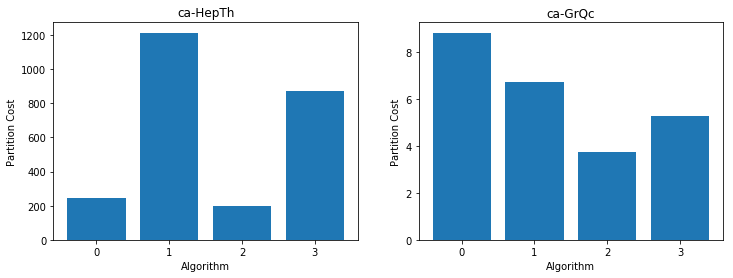

In [29]:
# calculate partition cost for all algorithms
paths = ['./graphs-1/ca-HepTh.txt', './graphs-1/ca-GrQc.txt']paths = ['./graphs-1/ca-HepTh.txt', './graphs-1/ca-GrQc.txt']
fig, axes = plt.subplots(ncols=len(paths), figsize=(12,4))

for i, file_path in enumerate(paths):
    values = open(file_path).read().split('\n')
    graph_info = values[0]
    print(graph_info)

    name = graph_info.split()[1]
    k = int(graph_info.split()[-1])
    graph = nx.read_edgelist(file_path)

    all_cost = []

    for algo in [1,2,3,4]:
        labels, partition_cost = spectral_clustering(graph, k, algo)
        all_cost.append(partition_cost)
        
    # plot    
    y_pos = [0,1,2,3]
    axes[i].bar(y_pos, all_cost, align='center')
    axes[i].set_ylabel('Partition Cost')
    axes[i].set_xlabel('Algorithm')
    axes[i].set_xticks(y_pos)
    axes[i].set_title(name)

For both algorithms, [Normalized spectral clustering (generalized eigenproblem) W normalized U](#algo3) has the lowest (best) partition score thus produces the most balanced graph partition.

In [ ]:
labels, partition_cost = spectral_clustering(graph, k, 3)

In [ ]:
def labels_output(graph_path, labels):
    graph_name = graph_path.split('.txt')[0]
    output_path = graph_name + "_labels.txt"
    print(output_path)
    file = open(output_path, "w")
    
    for i in range(len(labels)):
        label = labels[i]
        line = '%s %s\n' % (i, label)
        file.write(line)

In [ ]:
paths = ['./graphs-1/ca-HepTh.txt', './graphs-1/ca-GrQc.txt']
for file_path in paths:
    labels_output(file_path, labels)